In [14]:
import sys
sys.version

'3.10.13 (main, Sep 11 2023, 13:21:10) [GCC 11.2.0]'

In [8]:
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
import joblib
warnings.filterwarnings("ignore")

tf.__version__

'2.13.0'

In [16]:
df = pd.read_csv("Datasets/US_Crime_Data.csv")
df.head()

,Date,Title,Organization,City,State,URL,Keyword,Summary
0,2/13/17 9:01,Pizza Hut driver who killed co-worker with sho...,LGBTQ Nation,Phoenix,AZ,http://www.lgbtqnation.com/2017/02/man-accused...,NaN,NaN
1,2/13/17 9:37,Residents of NJ township receiving KKK promoti...,New York Daily News,NaN,NaN,http://www.nydailynews.com/news/national/resid...,NaN,NaN
2,2/13/17 15:37,House OKs bill to expand Kentucky's hate crime...,FOX19,Cincinnati,OH,http://www.fox19.com/story/34494432/house-oks-...,NaN,NaN
3,2/13/17 16:56,"Amid Protests, 'Blue Lives Matter' Bill Passes...",89.3 WFPL,Louisville,KY,http://wfpl.org/amid-protests-blue-lives-matte...,NaN,NaN
4,2/13/17 18:37,Lafourche inmates charged with hate crimes in ...,Daily Comet,Thibodaux,LA,http://www.dailycomet.com/news/20170213/lafour...,NaN,NaN


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6783 entries, 0 to 6782
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          6783 non-null   object
 1   Title         6782 non-null   object
 2   Organization  6783 non-null   object
 3   City          5616 non-null   object
 4   State         5538 non-null   object
 5   URL           6783 non-null   object
 6   Keyword       5607 non-null   object
 7   Summary       4527 non-null   object
dtypes: object(8)
memory usage: 424.1+ KB


In [18]:
df.isnull().sum()

Date               0
Title              1
Organization       0
City            1167
State           1245
URL                0
Keyword         1176
Summary         2256
dtype: int64

In [19]:
df.dropna(subset="Title", inplace=True)
df.isnull().sum()

Date               0
Title              0
Organization       0
City            1167
State           1245
URL                0
Keyword         1176
Summary         2256
dtype: int64

In [20]:
import string
import pandas as pd

df = df[["Title"]]
punctuation = set(string.punctuation)

def preprocess(text):
    arr = [i for i in text if i not in punctuation]
    return "".join(arr).lower()
            
sentences = df["Title"].apply(preprocess)
sentences

0       pizza hut driver who killed coworker with shot...
1       residents of nj township receiving kkk promoti...
2       house oks bill to expand kentuckys hate crimes...
3       amid protests blue lives matter bill passes ke...
4       lafourche inmates charged with hate crimes in ...
                              ...                        
6778    police rash of vandalism on margate menorahs i...
6779    exstudent accused of smearing used tampon on r...
6780    queensbury woman charged with hate crime again...
6781    hate crime hartford student accused of smearin...
6782    police make arrest following alleged hate crim...
Name: Title, Length: 6782, dtype: object

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequence = tokenizer.texts_to_sequences(sentences)
print("Ttoal Words", len(tokenizer.word_index))
sequence[:5]

Ttoal Words 7568


[[3973, 3974, 450, 47, 88, 3975, 12, 2211, 103, 1370, 2803],
 [830, 4, 423, 1558, 2212, 470, 3976, 672],
 [257, 1846, 75, 5, 593, 3977, 1, 6, 36],
 [721, 898, 480, 274, 301, 75, 481, 634, 257],
 [3978, 2804, 16, 12, 1, 6, 3, 424, 19]]

In [11]:
from tensorflow.keras.utils import to_categorical, pad_sequences

x, y = [], []
skipped_words = 0

for seq in sequence:
    if len(seq) > 1:
        for j in range(1, len(seq)):
            x.append(seq[:j])  
            y.append(seq[j])  
    else:
        skipped_words += 1

x = pad_sequences(x, maxlen=50)
y = to_categorical(y)

x = np.array(x, dtype=np.float16)
y = np.array(y, dtype=np.float16)
x.shape, y.shape

((64701, 50), (64701, 7569))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout, GRU

model = Sequential([
    Embedding(input_dim=y.shape[1], output_dim=500, input_length=50),
    Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.1)),
    Bidirectional(LSTM(units=64, return_sequences=False, dropout=0.1)),
    Dense(units=32, activation=tf.nn.relu),
    Dropout(0.1),
    Dense(units=y.shape[1], activation=tf.nn.softmax)
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.CategoricalCrossentropy(),
    metrics= ["accuracy"]
    )
hist = model.fit(
    x, y,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss")]
    )

In [120]:
model.save("/kaggle/working/TF_Model_500.h5")

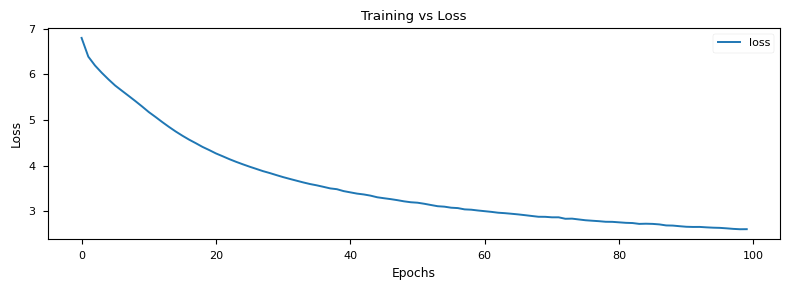

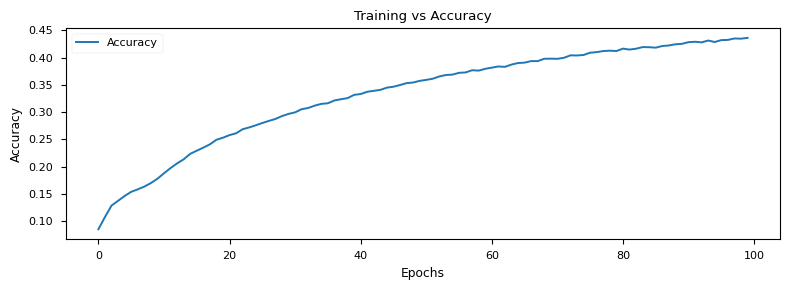

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(history):
    plt.style.use('seaborn-paper')
    plt.figure(figsize=(8, 3))
    plt.plot(history.history["loss"], label="loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Loss")
    plt.tight_layout()
    plt.legend()
    
    plt.figure(figsize=(8, 3))
    plt.plot(history.history["accuracy"], label="Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Accuracy")
    plt.tight_layout()
    plt.legend()
    return plt.show()

plot_metrics(hist)

In [121]:
from tensorflow.keras.models import load_model

load_model = load_model("/kaggle/working/TF_Model_500.h5")
load_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 500)           3784500   
                                                                 
 bidirectional_13 (Bidirect  (None, 50, 256)           644096    
 ional)                                                          
                                                                 
 bidirectional_14 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dense_24 (Dense)            (None, 32)                4128      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 7569)             

In [122]:
import time
text = "police"

def predict_next_word(text):
    for i in range(7):
      token_text = tokenizer.texts_to_sequences([text])[0]
      padded_token_text = pad_sequences([token_text])
      pos = np.argmax(load_model.predict(padded_token_text))

      for word,index in tokenizer.word_index.items():
        if index == pos:
          text = text + " " + word
          print(text)
          time.sleep(1)
        
predict_next_word(text)

1/1 [==============================] - 1s 1s/step
police man
1/1 [==============================] - 1s 1s/step
police man arrested
1/1 [==============================] - 0s 22ms/step
police man arrested in
1/1 [==============================] - 0s 21ms/step
police man arrested in connection
1/1 [==============================] - 0s 21ms/step
police man arrested in connection with
1/1 [==============================] - 0s 24ms/step
police man arrested in connection with hate
1/1 [==============================] - 0s 21ms/step
police man arrested in connection with hate speech
